You can check [here](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md) to get needed environment, but you don't need to worry it in colab.

In [27]:
## install dependencies: (use cu101 because colab has CUDA 10.1)
#!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
#!pip install cython pyyaml==5.1
#!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
#!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
#!pip3 install opencv-python

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
import cv2
!gcc --version

1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [28]:
!git clone https://github.com/tangsanli5201/DeepPCB

fatal: destination path 'DeepPCB' already exists and is not an empty directory.


In [29]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [30]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow
from PIL import Image
import IPython
def cv2_imshow(img):
    img = img[:,:,[2,1,0]]
    img = Image.fromarray(img)
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

We have to take the data out from the .txt file.

In [5]:
import csv
train, test = [],[]
def take_path(x,d):
    with open(d) as t:
        #print(t.read())
        #print(type(csv.reader(t)))
        tmp = csv.reader(t,delimiter=' ')
        for i in tmp:
            x.append(i)
        for ele in x:
            ele[0] = './DeepPCB/PCBData/'+ele[0][:-4]+'_test.jpg'
            ele[1] = './DeepPCB/PCBData/'+ele[1]

take_path(test,'./DeepPCB/PCBData/test.txt')
print(test[:2])
take_path(train,'./DeepPCB/PCBData/trainval.txt')
print(train[:2])

[['./DeepPCB/PCBData/group20085/20085/20085291_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085291.txt'], ['./DeepPCB/PCBData/group20085/20085/20085292_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085292.txt']]
[['./DeepPCB/PCBData/group20085/20085/20085000_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085000.txt'], ['./DeepPCB/PCBData/group20085/20085/20085001_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085001.txt']]


In [6]:
height, width = cv2.imread(test[0][0]).shape[:2]
print(height, width)

640 640


# New Section

In [7]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#DatasetCatalog.clear()
#If you want to clear the data you registered, uncomment the upper line.

def get_PCB_dict(data_list):
    dataset_dicts = []
    
    for i,path in enumerate(data_list):
        filename = path[0]
        height, width = cv2.imread(filename).shape[:2]
        record = {}
        record['file_name'] = filename
        record['image_id'] = i
        record['height']= height
        record['width']= width
        
        
        objs = []
        with open(path[1]) as t:
            lines = t.readlines()
            for line in lines:
                if line[-1]=="\n":
                  box = line[:-1].split(' ')
                else:
                  box = line.split(' ')


                boxes = list(map(float,[box[0],box[1],box[2],box[3]]))
                category = int(box[4])

                obj = {
                    "bbox": boxes,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    #"segmentation": [poly], To draw a line, along to ballon
                    #you will need this for mask RCNN
                    "category_id": category-1,
                    "iscrowd": 0
                }
                objs.append(obj)
            record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts #list of dicts

In [8]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d,x in [("train",train), ("test",test)]:
    DatasetCatalog.register("PCB_" + d, lambda x=x: get_PCB_dict(x))
    MetadataCatalog.get("PCB_" + d).set(thing_classes=["open", "short", "mousebite", "spur", "copper", "pin-hole"],thing_colors=[(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255)])
    #I set the colors, but it's no use. Retry after training.
PCB_metadata = MetadataCatalog.get("PCB_train")

In [9]:
#check dataset
print(type(PCB_metadata))
MetadataCatalog.get("PCB_test")

<class 'detectron2.data.catalog.Metadata'>


namespace(name='PCB_test',
          thing_classes=['open',
                         'short',
                         'mousebite',
                         'spur',
                         'copper',
                         'pin-hole'],
          thing_colors=[(255, 0, 0),
                        (0, 255, 0),
                        (0, 0, 255),
                        (255, 255, 0),
                        (255, 0, 255),
                        (0, 255, 255)])

Get all the data and check the content inside

In [10]:
dataset_dicts = get_PCB_dict(train)

In [11]:
print(dataset_dicts[0])
print(dataset_dicts[1])

{'file_name': './DeepPCB/PCBData/group20085/20085/20085000_test.jpg', 'image_id': 0, 'height': 640, 'width': 640, 'annotations': [{'bbox': [409.0, 394.0, 435.0, 422.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}, {'bbox': [275.0, 383.0, 319.0, 417.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}, {'bbox': [8.0, 163.0, 36.0, 191.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}, {'bbox': [244.0, 151.0, 270.0, 182.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 4, 'iscrowd': 0}, {'bbox': [338.0, 519.0, 364.0, 543.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 5, 'iscrowd': 0}, {'bbox': [476.0, 460.0, 502.0, 481.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}]}
{'file_name': './DeepPCB/PCBData/group20085/20085/20085001_test.jpg', 'image_id': 1, 'height': 640, 'width': 640, 'annotations': [{'bbox': [335.0, 208.0, 364.0, 233.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, '

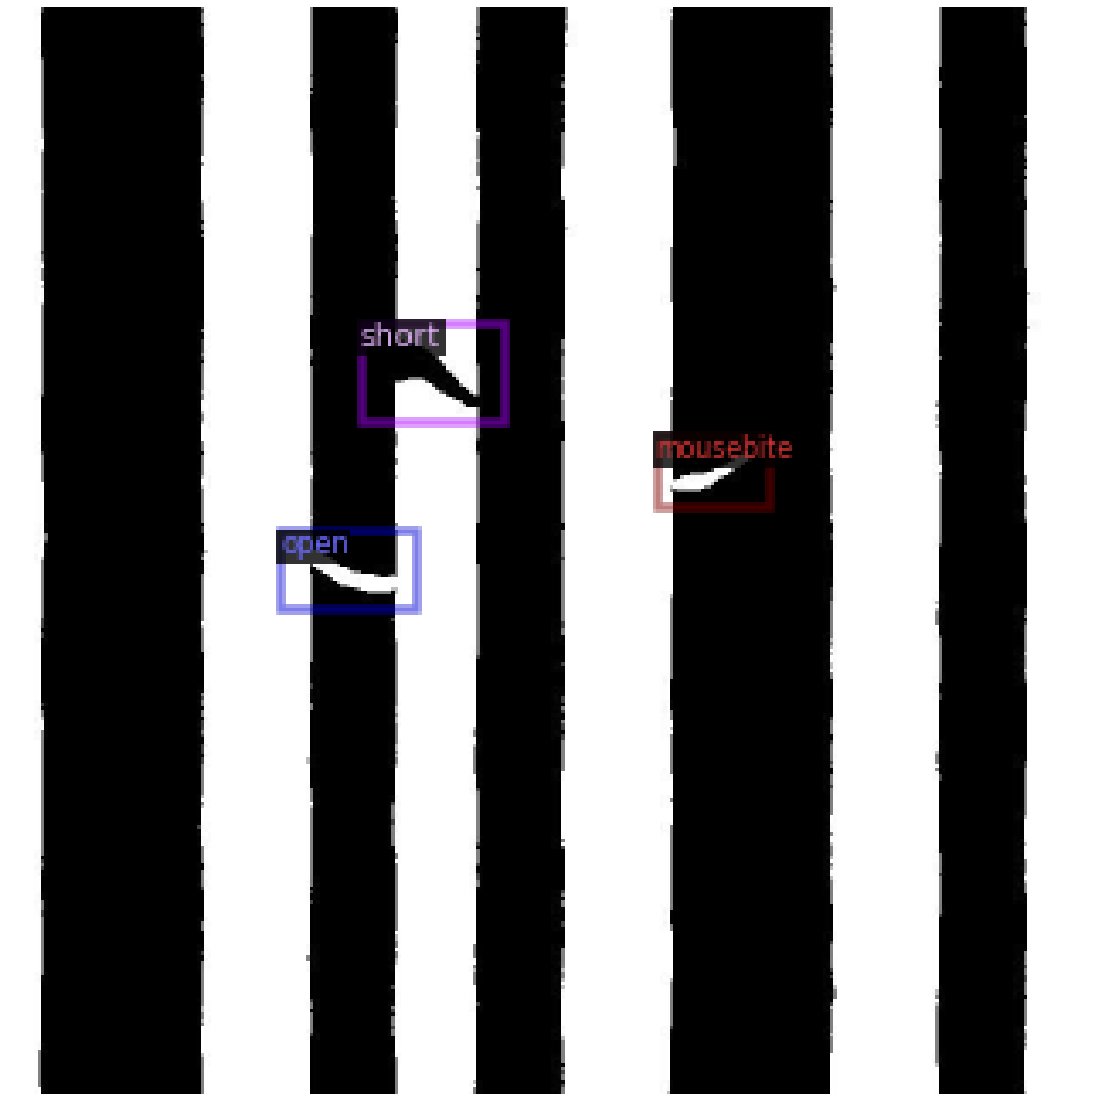

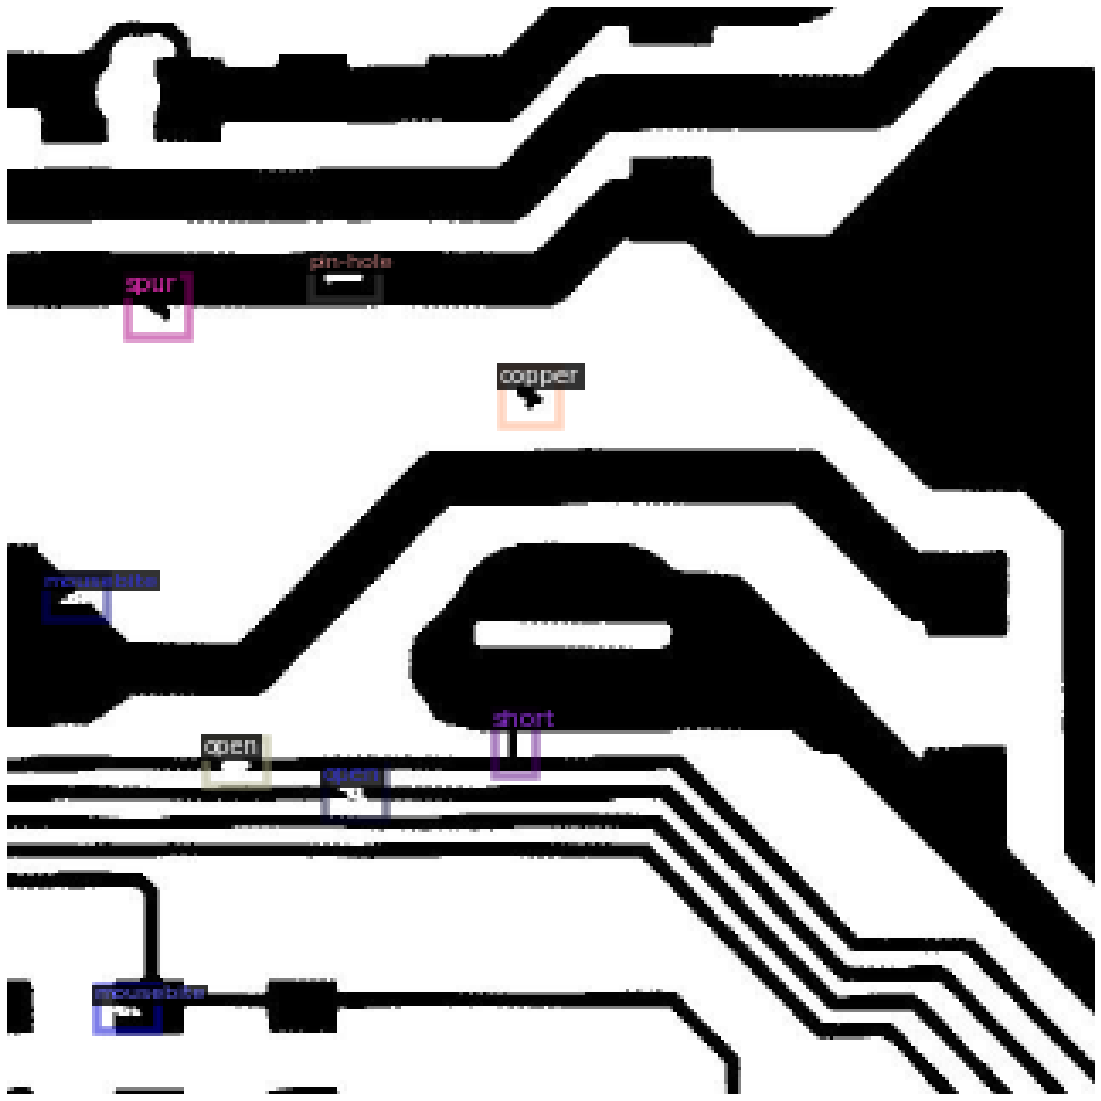

In [12]:
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=PCB_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [13]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("PCB_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 30    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
#trainer.resume_or_load(resume=False)
trainer.train()
#It will train about 20 minutes in colab.

[05/22 14:49:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[05/22 14:49:32 d2.data.build]: Removed 0 images with no usable annotations. 1000 images left.
[05/22 14:49:32 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    open    | 1283         |   short    | 1028         | mousebite  | 1379         |
|    spur    | 1142         |   copper   | 1010         |  pin-hole  | 1031         |
|            |              |            |              |            |              |
|   total    | 6873         |            |              |            |              |
[05/22 14:49:32 d2.data.common]: Serializing 1000 elements to byte tensors and concatenating them all ...
[05/22 14:49:32 d2.data.common]: Serialized dataset takes 0.59 MiB
[05/22 14:49:32 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 7

In [25]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("PCB_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume#_or_load(resume=False)
trainer.train()
#It will train about 20 minutes in colab.

[05/22 14:57:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[05/22 14:57:07 d2.data.build]: Removed 0 images with no usable annotations. 1000 images left.
[05/22 14:57:07 d2.data.common]: Serializing 1000 elements to byte tensors and concatenating them all ...
[05/22 14:57:07 d2.data.common]: Serialized dataset takes 0.59 MiB
[05/22 14:57:07 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/22 14:57:07 d2.data.build]: Using training sampler TrainingSampler


AttributeError: 'DefaultTrainer' object has no attribute 'resume'

In [18]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("PCB_test", )
predictor = DefaultPredictor(cfg)

In [19]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_PCB_dict(test)

tensor([1, 1, 5, 1, 1], device='cuda:0')
Boxes(tensor([[ 87.0473, 397.0208, 106.2559, 425.3051],
        [232.7746, 293.5492, 259.7843, 321.4059],
        [312.2471, 279.6479, 346.2395, 309.9110],
        [193.6874, 116.8691, 218.2634, 146.3073],
        [474.8326, 152.4722, 504.9498, 237.0033]], device='cuda:0'))


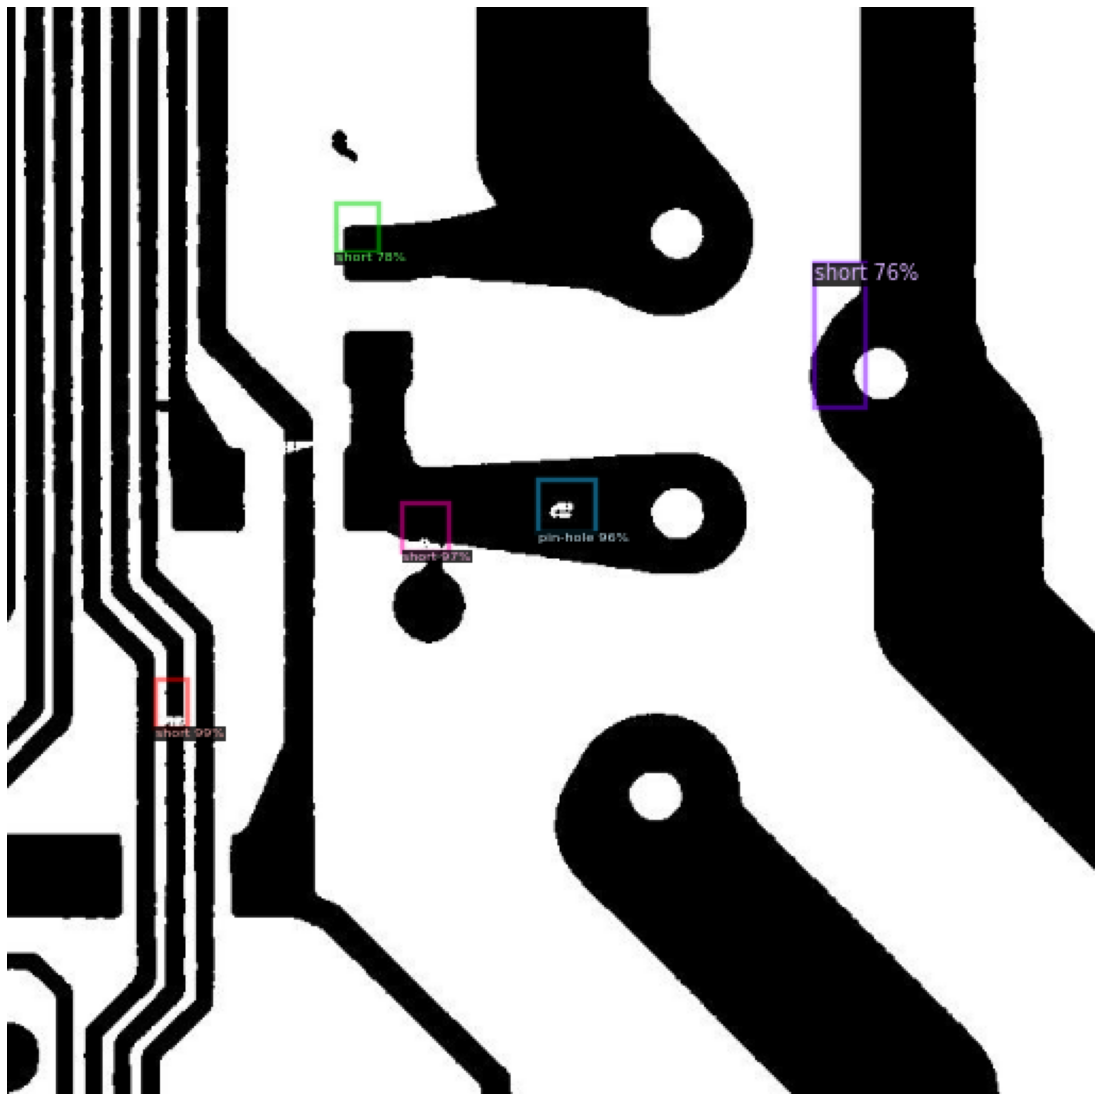

tensor([1, 3, 5, 5, 5], device='cuda:0')
Boxes(tensor([[336.2379, 370.4406, 359.0807, 394.1432],
        [324.6274, 375.4745, 353.5032, 401.3658],
        [241.4335, 547.5021, 271.2544, 574.3372],
        [173.2665, 204.0322, 210.4762, 228.7951],
        [490.9663, 469.6195, 526.9914, 493.4030]], device='cuda:0'))


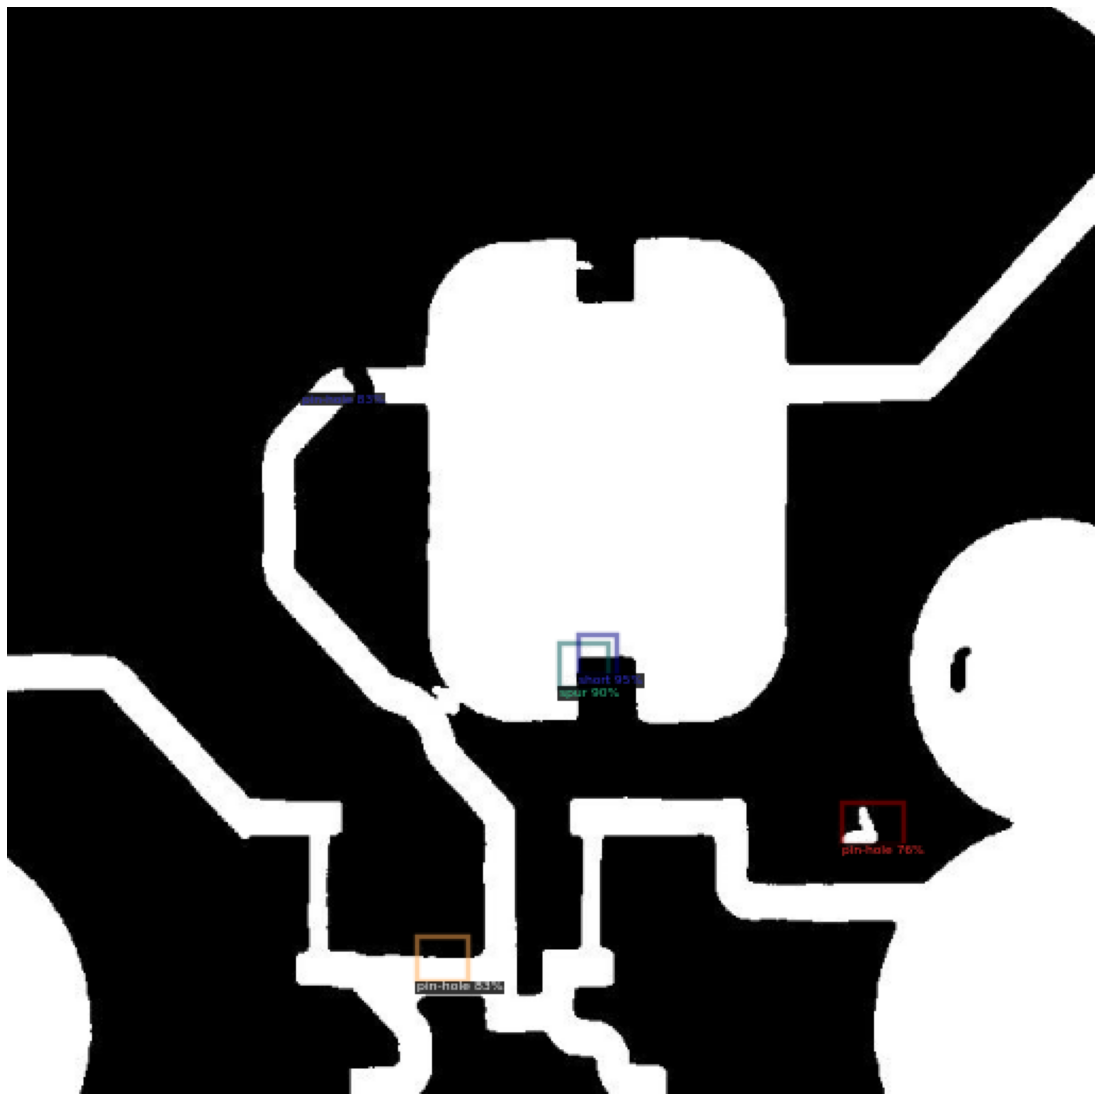

tensor([5, 5], device='cuda:0')
Boxes(tensor([[316.6661, 468.7230, 345.8531, 499.9199],
        [311.5240, 474.1265, 358.1206, 495.2900]], device='cuda:0'))


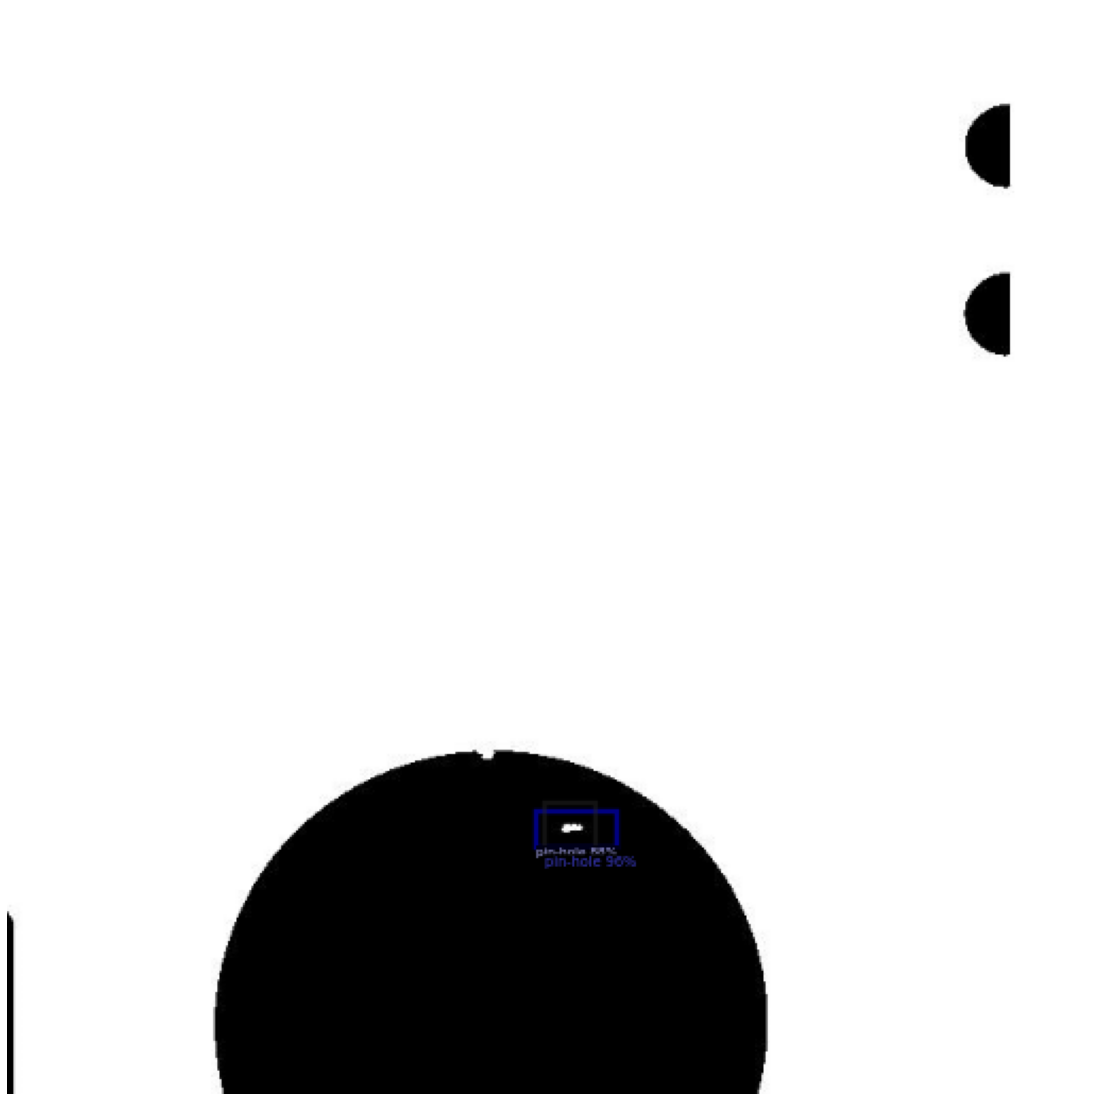

In [20]:
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im,
                   metadata=PCB_metadata, 
                   scale=0.8,
                   instance_mode =  ColorMode.IMAGE
        )
                   # remove the colors of unsegmented pixels
    print(outputs['instances'].pred_classes)
    print(outputs["instances"].pred_boxes)

    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image())

In [21]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("PCB_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "PCB_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [05/22 14:54:09 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'PCB_test'. Trying to convert it to COCO format ...
[05/22 14:54:09 d2.data.datasets.coco]: Converting annotations of dataset 'PCB_test' to COCO format ...)
[05/22 14:54:10 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/22 14:54:10 d2.data.datasets.coco]: Conversion finished, #images: 500, #annotations: 3140
[05/22 14:54:10 d2.data.datasets.coco]: Caching COCO format annotations at './output/PCB_test_coco_format.json' ...
[05/22 14:54:11 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    open    | 659          |   short    | 478          | mousebite  | 586          |
|    spur    | 483          |   copper   | 464          |  pin-hole  | 470          |
|            |        

OrderedDict([('bbox',
              {'AP': 2.7030008286404774,
               'AP50': 8.09516132137382,
               'AP75': 0.9027564149749232,
               'APs': 3.115653099798097,
               'APm': 2.9391767696710063,
               'APl': 0.0,
               'AP-open': 0.798955501213289,
               'AP-short': 0.018260550600824495,
               'AP-mousebite': 0.2565333534764872,
               'AP-spur': 0.2033378253774644,
               'AP-copper': 3.952188054507175,
               'AP-pin-hole': 10.988729686667625})])